In [ ]:
# MIT License
#
# Copyright (c) 2021 Fagner Cunha
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Embarcando modelos com TensorFlow Lite

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/alcunha/embedding-tflite-models-on-raspberrypi/blob/master/Embedding-Models-with-TFLite.ipynb"><img src="./images/colab_logo_32px.png" />Executar no Google Colab</a>
  </td>
  <td>
    <a href="https://github.com/alcunha/embedding-tflite-models-on-raspberrypi/blob/master/Embedding-Models-with-TFLite.ipynb"><img src="./images/GitHub-Mark-32px.png" />Ver código no GitHub</a>
  </td>
</table>

In [ ]:
! pip install tensorflow

In [1]:
import os

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

AUTOTUNE = tf.data.experimental.AUTOTUNE

#### Carregamento do dataset

Será utilizado um subconjunto de 2 mil imagens do dataset Cats vs Dogs [1]

In [2]:
CATS_DOGS_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_path = keras.utils.get_file('cats_and_dogs.zip', origin=CATS_DOGS_URL, extract=True)
dataset_path = os.path.join(os.path.dirname(zip_path), 'cats_and_dogs_filtered')
train_path = os.path.join(dataset_path, 'train')
validation_path = os.path.join(dataset_path, 'validation')

In [3]:
INPUT_SIZE = 224
BATCH_SIZE = 1
classes = ['cats', 'dogs']

#### Preparação do pipeline de dados

In [4]:
def string_to_one_hot(label):
    one_hot = tf.stack([tf.equal(label, s) for s in classes], axis=-1)
    one_hot = tf.cast(one_hot, tf.float32)
    
    return one_hot

In [5]:
def get_label_from_filename(filename):
    label = tf.strings.split(filename, os.path.sep)[-2]
    label = string_to_one_hot(label)
    
    return filename, label

In [6]:
def load_and_preprocess_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, size=(INPUT_SIZE, INPUT_SIZE))
    
    return image, label

In [7]:
dataset = tf.data.Dataset.list_files(str(validation_path+'/*/*'), shuffle=True)
dataset = dataset.map(get_label_from_filename, num_parallel_calls=AUTOTUNE)
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)

Classe: dogs


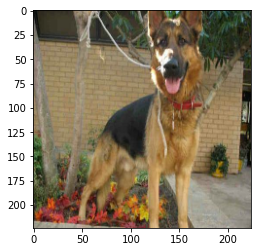

In [8]:
image, label = next(iter(dataset))
print("Classe: %s" % classes[tf.argmax(label[0])])
plt.imshow(image[0])

#### Carregamento do modelo treinado

A acurácia do modelo na base de validação é de 98.60%.

In [9]:
base_model = MobileNetV2(input_shape=(INPUT_SIZE,INPUT_SIZE,3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])

In [10]:
model.load_weights('mobilenetv2_cats_and_dogs_08jan.h5')

A compilação do modelo é necessária para utilizar a função evaluate para avaliar o modelo:

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.evaluate(dataset, batch_size=1)

1000/1000 [==============================] - 5s 5ms/step - loss: 0.0413 - accuracy: 0.9860


[0.04133123159408569, 0.9860000014305115]

In [13]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

block_8_expand_BN (BatchNormali (None, 14, 14, 384)  1536        block_8_expand[0][0]             
__________________________________________________________________________________________________
block_8_expand_relu (ReLU)      (None, 14, 14, 384)  0           block_8_expand_BN[0][0]          
__________________________________________________________________________________________________
block_8_depthwise (DepthwiseCon (None, 14, 14, 384)  3456        block_8_expand_relu[0][0]        
__________________________________________________________________________________________________
block_8_depthwise_BN (BatchNorm (None, 14, 14, 384)  1536        block_8_depthwise[0][0]          
__________________________________________________________________________________________________
block_8_depthwise_relu (ReLU)   (None, 14, 14, 384)  0           block_8_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_8_pr

### Referências

[1] Elson, Jeremy, et al. "Asirra: a CAPTCHA that exploits interest-aligned manual image categorization." ACM Conference on Computer and Communications Security. Vol. 7. 2007.